# Equal Weighted vs Value Weighted Portfolio Construction

In [107]:
#collapse

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

## The Data

Dartmouth College, through their Fama-French Data Library, offers an extensive array of raw data and factor portfolios going back to 1926.  We will be utilizing the 49 Industry Portfolio dataset, analzying monthly data from January, 2000 to September, 2020.  This time period will encompass 3 full market cycles, which will enable a more robust analysis of the various allocation methodologies.

The data can be downloaded here: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

We wil begin by importing monthly return data for both the value-weighted and equal-weighted company portfolios.  These portfolios denote the weighting of the individual company in each industry.  For example, if there are 44 firms in the `Cnstr` industry, the equal-weighted portfolio will assume an allocation of $\frac{1}{44}$, or more generally $\frac{1}{N}$, to each company. 

Additionally, we will import the datasets for both the average firm size in each industry and the number of firms in each industry to be able to calculate a cap-weighted (value-weighted) index.  
* (This is not to be confused with the above. First, we separate how each industry is weighted to each company; then we determine how we allocate to each industry; value vs equal).

In [10]:
# importing the monthly value-weighted returns for 49 industries
m_vw_rets = pd.read_csv('data/ind49_m_vw_rets.csv', header=0, index_col=0, parse_dates=True) / 100
# convert the index to equal the date, for time-series analysis
m_vw_rets.index = pd.to_datetime(m_vw_rets.index, format="%Y%m").to_period('M')
# eliminate white space in column names for easier indexing
m_vw_rets.columns = m_vw_rets.columns.str.strip()
m_vw_rets = m_vw_rets["2000":]

The Industries that this dataset uses are:

In [105]:
m_vw_rets.columns

Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero',
       'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm',
       'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips', 'LabEq', 'Paper', 'Boxes',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin',
       'Other'],
      dtype='object')


In [11]:
# importing the monthly equal-weighted returns for 49 industries
m_ew_rets = pd.read_csv('data/ind49_m_ew_rets.csv', header=0, index_col=0, parse_dates=True) / 100
m_ew_rets.index = pd.to_datetime(m_ew_rets.index, format="%Y%m").to_period('M')
m_ew_rets.columns = m_ew_rets.columns.str.strip()
m_ew_rets = m_ew_rets["2000":]

We have imported and cleaned the returns data for both equal-weighted company portfolios and value-weighted portfolios.  Next we will bring in the average firm size and number of firms, so we can create a total-market value-weighted portfolio for both value-weighted industries and equal-weighted industries.

In [18]:
# importing and formatting the monthly average firm size and number of firms datasets
ind_size = pd.read_csv('data/ind49_m_size.csv', header=0, index_col=0, parse_dates=True)
ind_size.index = pd.to_datetime(ind_size.index, format="%Y%m").to_period('M')
ind_size.columns = ind_size.columns.str.strip()
ind_size = ind_size["2000":]

ind_nfirms = pd.read_csv ('data/ind49_m_nfirms.csv', header=0, index_col=0, parse_dates=True)
ind_nfirms.index = pd.to_datetime(ind_nfirms.index, format="%Y%m").to_period('M')
ind_nfirms.columns = ind_nfirms.columns.str.strip()
ind_nfirms = ind_nfirms["2000":]

In order to create the total-market value-weighted portfolios for each industry-weighted portfolio, we will write a quick function to do the calculation.  Then we will create those portfolios and combine all 4 into a DataFrame

In [19]:
def value_weighted_returns(ind_returns, ind_size, ind_nfirms):
    # Calculate the market cap for each industry
    ind_mktcap = ind_size * ind_nfirms
    # Colculate the total market cap for all industries
    total_mktcap = ind_mktcap.sum(axis="columns")   
    # Calculate the weighting of each industry in the total market cap
    ind_cap_wgt = ind_mktcap.divide(total_mktcap, axis = "rows")
    # Calcualte the total market return for each period
    total_market_return = (ind_cap_wgt * ind_returns).sum(axis="columns")
    
    return total_market_return

In [50]:
# Calculate the value-weighted portfolio market returns for the value-weighted industries
m_vw_vw_rets = value_weighted_returns(m_vw_rets, ind_size, ind_nfirms)

# Calculate the value-weighted portfolio market returns for the equal-weighted industries
m_vw_ew_rets = value_weighted_returns(m_ew_rets, ind_size, ind_nfirms)

Calculating the equal-weighted industry portfolios is simply and average return across all industries.  We will make that calculation here.

In [51]:
# Calculate the equal-weighted portfolios returns for the value-weigthed industries
m_ew_vw_rets = m_vw_rets.mean(axis="columns")

# Calculate the equal-weighted portfolios returns for the equal-weigthed industries
m_ew_ew_rets = m_ew_rets.mean(axis="columns")

In [53]:
returns = pd.DataFrame({
    "Value-Weighted - EW Port": m_vw_ew_rets,
    "Value-Weighted - VW Port": m_vw_vw_rets,
    "Equal-Weighted - EW Port": m_ew_ew_rets,
    "Equal-Weighted - VW Port": m_ew_vw_rets,
})

returns

,Value-Weighted - EW Port,Value-Weighted - VW Port,Equal-Weighted - EW Port,Equal-Weighted - VW Port
2000-01,0.070894,-0.040130,0.044173,-0.033673
2000-02,0.188816,0.019456,0.090876,-0.021078
2000-03,-0.005319,0.074055,0.022084,0.076998
2000-04,-0.113548,-0.045298,-0.056082,-0.003986
2000-05,-0.070897,-0.030830,-0.040545,-0.016059
...,...,...,...,...
2020-05,0.085765,0.055291,0.069798,0.055661
2020-06,0.069212,0.023037,0.073351,0.018688
2020-07,0.057484,0.058037,0.060947,0.060033
2020-08,0.051738,0.077836,0.051535,0.065782


Next, we will create some summary statistics to be to compare these portfolios.
* Annualized Returns: the compounded annualized return over the period.
    * $(1 + R_{t,t+1}) ^{n} - 1$
    
* Annualized Vol: the annualized standard deviation over the period
    * $ \sigma_R = \sqrt{\frac{1}{N}\sum_{i=1}^N(R_i - \bar{R})^2} $
    
* Sharpe Ratio: measures a unit of excess return over of the risk-free rate for each additional unit of risk.
    * $\text{Sharpe Ratio} = \frac{Return - Risk Free Rate}{Volatility} $
    
* Max Drawdown: shows the largest percentage drop in a portfolio from a previous high valuation.

* Skewness: measures the distortion from a normal distribution
    * $S(R) = \frac{E[(R - E(R))^3]}{[Var(R)^{3/2}]}$
    
* Kurtosis: measures the thickness of the tails as compared to a normal distribution
    * $K(R) = \frac{E[(R - E(R))^4]}{[Var(R)^{2}]}$
    
* Histroic VaR (5%): represents the level in which 5% of historical period losses were greater than

* Cornish-Fisher VaR: parametric calculation of Value-at-Risk, which adjusts for the skewness and kurtosis of a distribution
    * $ \tilde{z_a} = z_a + \frac{1}{6}(z_a^2 - 1)S +  \frac{1}{24}(z_a^3 - 3Z_a)(K-3) - \frac{1}{36}(2z_a^3 - 5Z_a)S^2$  

In [111]:
def annualize_rets(returns, periods_per_year=12):
    # compound each years' return at 1+r
    compounded_growth = (1+returns).prod()
    # calculate the number of periods in ind_returns
    n_periods = returns.shape[0]
    
    return compounded_growth ** (periods_per_year / n_periods) - 1

def annualize_stdev(returns, periods_per_year=12):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, risk_free_rate=0, periods_per_year=12):
    # calculate the per period risk_free_rate
    rf_per_period = (1+risk_free_rate) ** (1/periods_per_year) - 1
    # calculate the excess return
    excess_ret = returns - rf_per_period
    # annualize the excess return
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    # calculate the annual volatility
    ann_sd = annualize_stdev(returns, periods_per_year)
    
    return ann_ex_ret / ann_sd

def max_drawdown(returns):
    # calculate the accumulated growth at each period
    compounded_growth = (1+returns).cumprod()
    # calculate the previous peak value at each period
    previous_peaks = compounded_growth.cummax()
    # calculate the drawdowns at each period
    drawdowns = (compounded_growth - previous_peaks) / previous_peaks
    
    return -drawdowns.min()

def skewness(returns):
    # calculate each period's return difference from the average return
    demeaned_r = returns - returns.mean()
    # calculate the standard devistion of the portfolio
    sigma_r = returns.std(ddof=0)  # using ddof=0, to calculate population standard deviation
    # caluclate the numerator in the equation
    exp = (demeaned_r**3).mean()
    
    return exp / sigma_r**3

def kurtosis(returns):
    # calculate each period's return difference from the average return
    demeaned_r = returns - returns.mean()
    # calculate the standard devistion of the portfolio
    sigma_r = returns.std(ddof=0)  # using ddof=0, to calculate population standard deviation
    # caluclate the numerator in the equation
    exp = (demeaned_r**4).mean()
    
    return exp / sigma_r**4

def var_historic(returns, level=5):
    return -np.percentile(returns, level)

def var_cornish_fisher(returns, level=5):
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    # compute the skewness
    s = skewness(returns)
    # compute the kurtosis
    k = kurtosis(returns)
    # compute the adjusted Z score
    z = (z +
                 (z**2 - 1) * s/6 +
                 (z**3 - 3*z) * (k-3)/24 -
                 (2*z**3 - 5*z) * (s**2)/36
            )
    
    return -(returns.mean() + z * returns.std(ddof=0))

def summary_stats(returns, periods_per_year=12, risk_free_rate=0.02):
    
    summary_df = pd.DataFrame({
        "Annualized Return": returns.aggregate(annualize_rets, periods_per_year=periods_per_year),
        "Annualized Vol": returns.aggregate(annualize_stdev, periods_per_year=periods_per_year),
        "Sharpe Ratio": returns.aggregate(sharpe_ratio, risk_free_rate=risk_free_rate, 
                                              periods_per_year=periods_per_year),
        "Max Drawdown": returns.aggregate(max_drawdown),
        "Skewness": returns.aggregate(skewness),
        "Kurtosis": returns.aggregate(kurtosis),
        "Historic 5% VaR": returns.aggregate(var_historic),
        "CF 5% VaR": returns.aggregate(var_cornish_fisher)
    })
    
    return summary_df

In [112]:
summary_stats(returns)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis,Historic 5% VaR,CF 5% VaR
Value-Weighted - EW Port,0.091434,0.216458,0.323901,0.583520,-0.067811,4.919207,0.093561,0.092089
Value-Weighted - VW Port,0.066911,0.154981,0.297115,0.500088,-0.568248,3.966089,0.078383,0.073090
Equal-Weighted - EW Port,0.101640,0.207453,0.386287,0.598352,-0.271297,5.841772,0.087737,0.089501
Equal-Weighted - VW Port,0.088844,0.165339,0.408761,0.528351,-0.642084,5.549245,0.079556,0.075951


Additionally, let's take a look at the growth of these portfolios graphically.  First, we will create a cumulative returns DataFrame and then plot that.

<AxesSubplot:>

<Figure size 1008x432 with 0 Axes>

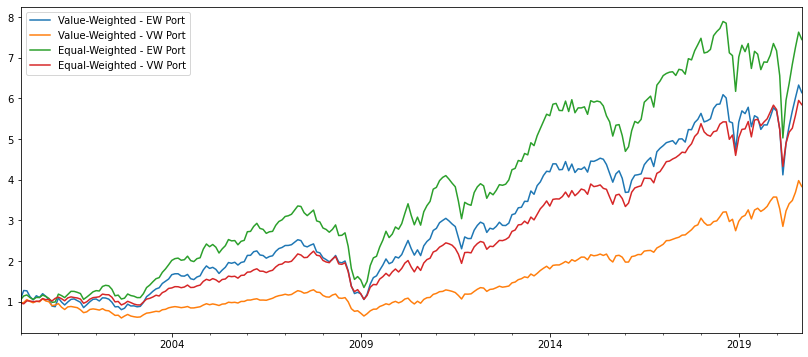

In [120]:
cum_returns = (1+returns).cumprod()

cum_returns.plot(figsize=(14,6))

### Takeaways

So, what can we take away from these tables.

**Equal-Weighted Company portfolio vs Value-Weighted Company Portfolios.**

It appears that for both industry weighting schemes; value-weight (9.14% vs 6.69%), equal-weight (10.16 vs 8.88%), the equally weighted company portfolios outperformed the value-weighted ones.  This may simply be explained to the small-cap vs large-cap bias.  And that can be seen in the increased volatility exhibited (21.65% vs 15.49% and 20.74 vs 16.53%) and increased Max Drawdowns (58.3% vs 50.0% and 59.8% vs 52.8%).  And further looking at the Sharpe Ratio of these portfolios it is not clear, what the best company weighting is, as there seems to be a clear trade-off of risk vs return.

**Equal-Weighted Industry portfolio vs Value-Weighted Industry Portfolios.**

Here, while holding the company-weighting constant, it is clear that equal-weighting the industries outperforms the value-weighted industry portfolios (10.16% vs 9.14% and 8.88% vs 6.69%).  And this is accomplished with little change in the volatility of the portfolios (20.74% vs 21.64% and 16.53% vs 15.50%).  This results in dramatically improved Sharpe Ratios (.38 vs .32 and 0.40 vs 0.30).

Overall, from a Sharpe Ratio perspective, the portfolio that performed best over this period and construction schemes was the Equal-Weighted Industry and Value-Weighted Company portfolio, with a Sharpe Ratio of 0.40.  